# EDA - Bureau

In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 0)

import missingno as msno
import seaborn as sns
from tqdm import tqdm
from IPython.display import display

sns.set_style('darkgrid')
tqdm.pandas()

In [135]:
bureau = pd.read_feather('../data/input/bureau.ftr')
bureau_balance = pd.read_feather('../data/input/bureau_balance.ftr')
display(bureau.head())
display(bureau_balance.head())

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [138]:
bureau_balance.groupby('SK_ID_BUREAU').count()

,MONTHS_BALANCE,STATUS
SK_ID_BUREAU,,
5001709,97,97
5001710,83,83
5001711,4,4
5001712,19,19
5001713,22,22
5001714,15,15
5001715,60,60
5001716,86,86
5001717,22,22


In [140]:
bureau_balance.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

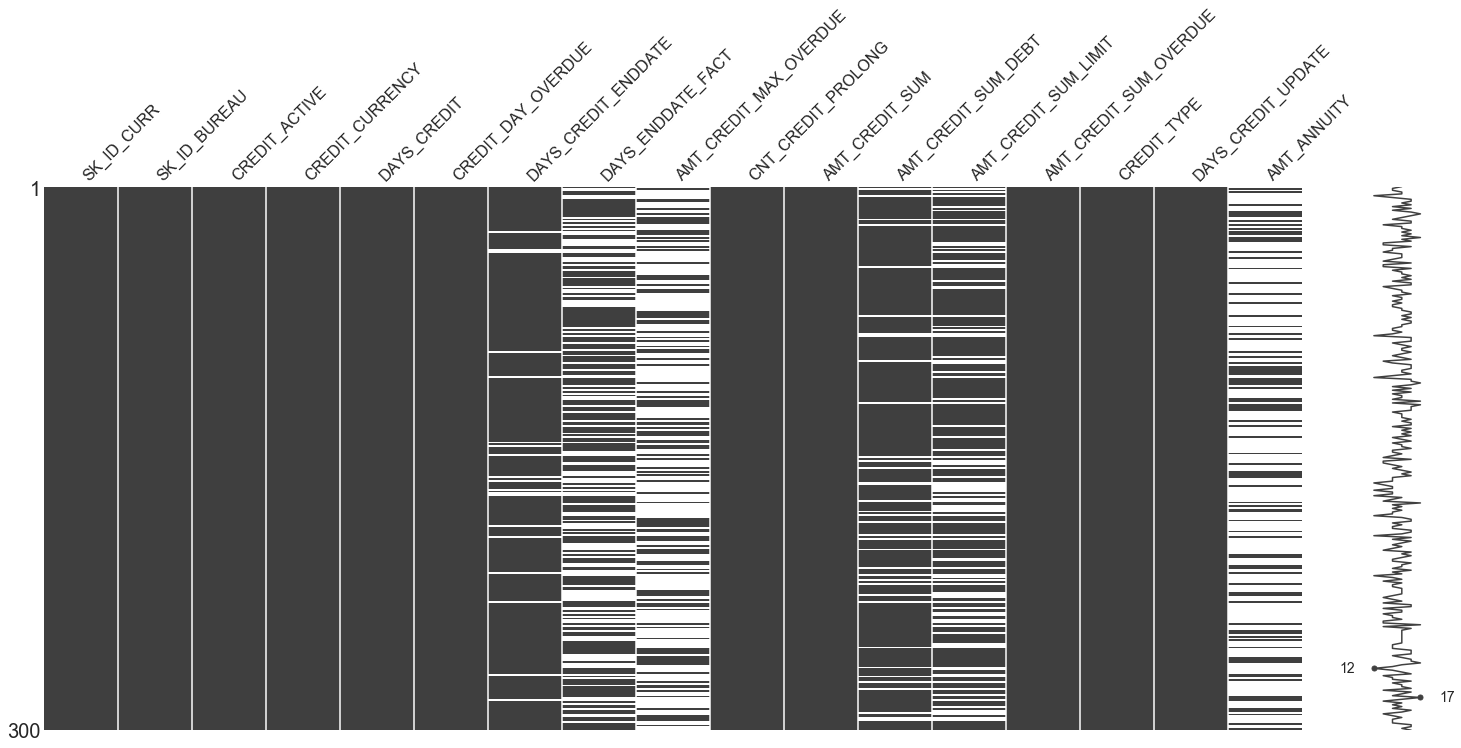

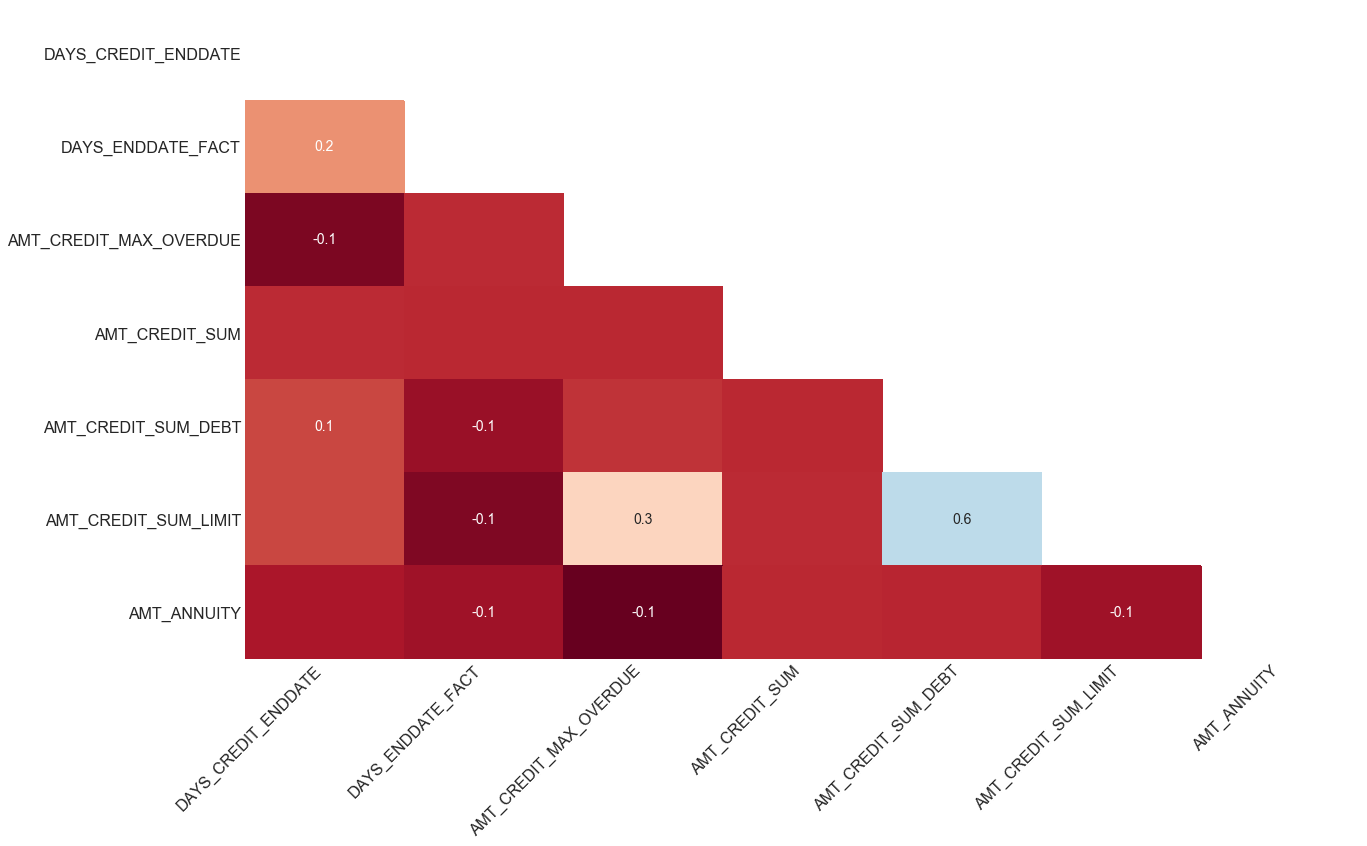

In [63]:
msno.matrix(bureau.sample(300))
plt.show()

msno.heatmap(bureau)
plt.show()

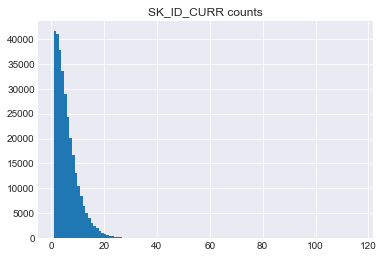

In [15]:
counts = bureau.SK_ID_CURR.value_counts()
counts.hist(bins=counts.max()-counts.min())
plt.title('SK_ID_CURR counts')
plt.show()

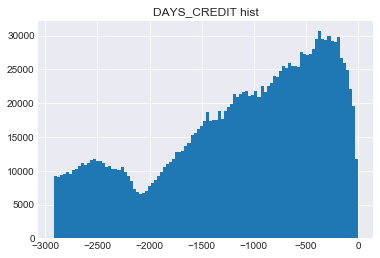

In [46]:
bureau.DAYS_CREDIT.hist(bins=100)
plt.title('DAYS_CREDIT hist')
plt.show()

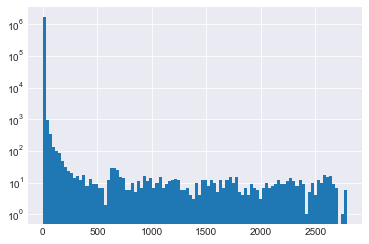

In [54]:
plt.hist(bureau.CREDIT_DAY_OVERDUE, bins=100, log=True)
plt.show()

In [91]:
bureau[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']].groupby('SK_ID_CURR').CNT_CREDIT_PROLONG.max().value_counts().sort_index()

0    297015
1      7316
2      1208
3       191
4        54
5        21
6         2
7         1
8         1
9         2
Name: CNT_CREDIT_PROLONG, dtype: int64

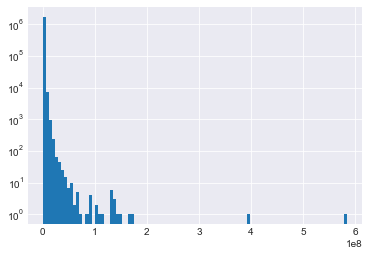

In [97]:
bureau.AMT_CREDIT_SUM.hist(bins=100, log=True)

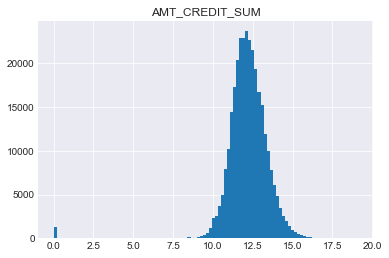

In [116]:
np.log1p(bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM']].groupby('SK_ID_CURR').mean()).hist(bins=100)
plt.show()

/Users/amane/.pyenv/versions/3.6.1/envs/compe/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


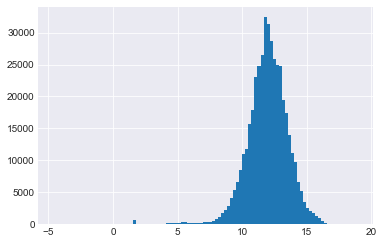

In [133]:
np.log1p(bureau.AMT_CREDIT_SUM_DEBT[bureau.AMT_CREDIT_SUM_DEBT!=0]).hist(bins=100)
plt.show()

/Users/amane/.pyenv/versions/3.6.1/envs/compe/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


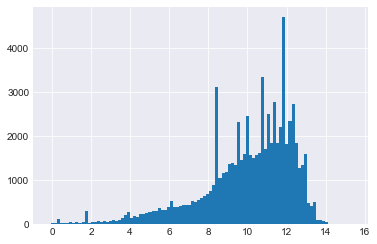

In [132]:
np.log1p(bureau.AMT_CREDIT_SUM_LIMIT[bureau.AMT_CREDIT_SUM_LIMIT!=0]).hist(bins=100)

In [129]:
bureau.CREDIT_TYPE.value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

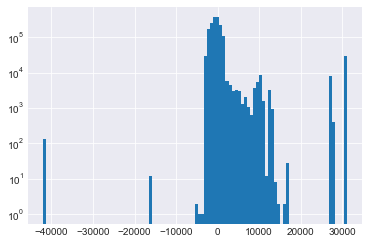

In [68]:
bureau.DAYS_CREDIT_ENDDATE.hist(bins=100, log=True)

In [40]:
bureau.CREDIT_CURRENCY.value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

In [20]:
bureau.CREDIT_ACTIVE.value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [27]:
nunique = bureau[['SK_ID_CURR', 'CREDIT_ACTIVE']].groupby('SK_ID_CURR').CREDIT_ACTIVE.nunique()
nunique.value_counts()

2    210141
1     90756
3      4912
4         2
Name: CREDIT_ACTIVE, dtype: int64

In [35]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.000,0.000,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.000,171342.000,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.500,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.000,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.500,0,2700000.000,NaN,NaN,0.0,Consumer credit,-21,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.000,0,180000.000,71017.380,108982.620,0.0,Credit card,-31,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.000,0,42103.800,42103.800,0.000,0.0,Consumer credit,-22,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.000,0,76878.450,0.000,0.000,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.000,0,103007.700,0.000,0.000,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.000,0,4500.000,0.000,0.000,0.0,Credit card,-690,NaN


In [37]:
bureau.query("SK_ID_CURR in @nunique.to_frame().query('CREDIT_ACTIVE==1').index")

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
13,402440,5714475,Active,currency 1,-96,0,269.0,NaN,0.00,0,89910.000,76905.00,0.00,0.0,Consumer credit,-22,NaN
27,426155,5714498,Closed,currency 1,-1331,0,-994.0,-1023.0,1350.00,0,39433.500,0.00,0.00,0.0,Consumer credit,-1023,NaN
28,426155,5714499,Closed,currency 1,-2534,0,-2352.0,-2347.0,NaN,0,38830.500,0.00,0.00,0.0,Consumer credit,-2345,NaN
29,426155,5714500,Closed,currency 1,-845,0,-480.0,-480.0,0.00,0,67500.000,0.00,0.00,0.0,Consumer credit,-480,NaN
30,426155,5714501,Closed,currency 1,-529,0,-343.0,-343.0,0.00,0,182791.440,0.00,0.00,0.0,Consumer credit,-337,NaN
158,351919,5714658,Active,currency 1,-769,0,1057.0,NaN,NaN,0,409500.000,295542.00,0.00,0.0,Consumer credit,-14,NaN
163,389074,5714667,Closed,currency 1,-957,0,-342.0,-341.0,NaN,0,13500.000,0.00,0.00,0.0,Credit card,-334,NaN
164,389074,5714668,Closed,currency 1,-705,0,-433.0,-404.0,NaN,0,135729.000,NaN,NaN,0.0,Consumer credit,-398,NaN
165,389074,5714669,Closed,currency 1,-1049,0,-378.0,-378.0,0.00,0,113496.885,0.00,0.00,0.0,Consumer credit,-372,NaN
180,286014,5714690,Active,currency 1,-137,0,27460.0,NaN,0.00,0,22500.000,18765.63,76.59,0.0,Credit card,-31,NaN


In [ ]:
bureau[['SK_ID_CURR', 'CREDIT_ACTIVE']].groupby('SK_ID_CURR').